👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [3]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install matplotlib==3.7.1
    !pip install pdpbox==0.2.0

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment.

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`).

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [38]:
# YOUR CODE HERE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.inspection import permutation_importance

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [5]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url)
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,2.0
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,0.0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,0.0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,0.0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,0.0


In [6]:
df.shape

(51916, 18)

In [7]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail', 'Serious Violations Found'],
      dtype='object')

In [8]:
type(df['Inspection Date'][0])

str

In [9]:
#lets convert the inspection date to DateTime
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])

In [10]:
type(df['Inspection Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
# Set 'Inspection Date' column as the index
df.set_index('Inspection Date', inplace=True)

In [12]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2017-09-15,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,2.0
2011-10-20,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,0.0
2016-04-05,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,0.0
2016-04-29,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,0.0
2011-01-10,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,0.0


**Task 1 Test**

In [11]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [13]:
df.isnull().sum()

Inspection ID                  0
DBA Name                       0
AKA Name                     623
License #                      5
Facility Type                224
Risk                          12
Address                        0
City                          53
State                         10
Zip                           26
Inspection Type                1
Violations                  9655
Latitude                     198
Longitude                    198
Location                     198
Fail                           0
Serious Violations Found    9655
dtype: int64

In [14]:
df.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail,Serious Violations Found
count,5.191600e+04,5.191100e+04,51890.000000,51718.000000,51718.000000,51916.000000,42261.000000
mean,1.330265e+06,1.549491e+06,60628.834669,41.879568,-87.676663,0.258610,0.279217
std,6.202664e+05,9.018283e+05,22.736963,0.081126,0.059509,0.437875,0.679656
min,4.425000e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000,0.000000
25%,6.796205e+05,1.140745e+06,60614.000000,41.830296,-87.707857,0.000000,0.000000
50%,1.424226e+06,1.958619e+06,60625.000000,41.890166,-87.666524,0.000000,0.000000
75%,1.946952e+06,2.215507e+06,60643.000000,41.939167,-87.634461,1.000000,0.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000,8.000000


In [15]:
df.describe(include = 'object')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Type,Violations,Location
count,51916,51293,51692,51904,51916,51863,51906,51915,42261,51718
unique,17049,16350,329,3,13954,39,1,51,42164,13410
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,654,802,34264,37731,741,51659,51906,24170,3,741


In [16]:
df['Serious Violations Found'].value_counts()

0.0    34508
1.0     4786
2.0     2148
3.0      627
4.0      155
5.0       19
6.0        9
8.0        5
7.0        4
Name: Serious Violations Found, dtype: int64

In [17]:
'''T2. Identify data leakage column.'''
leaky_col = 'Serious Violations Found'

**Task 2 Test**

In [18]:
'''T2 Test'''
# This is a hidden test.
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [19]:
df.select_dtypes('object').head(2) #select all categorical features

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Type,Violations,Location
Inspection Date,,,,,,,,,,
2017-09-15,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,"{'longitude': '-87.6447545707008', 'latitude':..."
2011-10-20,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,"{'longitude': '-87.68360273081268', 'latitude'..."


In [20]:
df.select_dtypes('object').nunique() > 500 #examining categorical features with more than 500 unique values

DBA Name            True
AKA Name            True
Facility Type      False
Risk               False
Address             True
City               False
State              False
Inspection Type    False
Violations          True
Location            True
dtype: bool

In [21]:
df.select_dtypes('object').nunique() < 2 # categorical columns that have only one category


DBA Name           False
AKA Name           False
Facility Type      False
Risk               False
Address            False
City               False
State               True
Inspection Type    False
Violations         False
Location           False
dtype: bool

In [22]:
df['City'].value_counts() # lets add this column to the one category variable

CHICAGO              51659
Chicago                 91
chicago                 34
CCHICAGO                16
SCHAUMBURG               6
CHicago                  5
MAYWOOD                  4
ELK GROVE VILLAGE        4
CHESTNUT STREET          3
CICERO                   3
OAK PARK                 2
CHICAGOCHICAGO           2
ELMHURST                 2
ROSEMONT                 2
SKOKIE                   2
EAST HAZEL CREST         2
NAPERVILLE               2
ALSIP                    2
NILES NILES              2
SCHILLER PARK            1
STREAMWOOD               1
CHICAGOHICAGO            1
BEDFORD PARK             1
OLYMPIA FIELDS           1
BROADVIEW                1
BRIDGEVIEW               1
CHICAGOI                 1
SUMMIT                   1
CHCHICAGO                1
EVANSTON                 1
BOLINGBROOK              1
OOLYMPIA FIELDS          1
HIGHLAND PARK            1
WORTH                    1
CHARLES A HAYES          1
CHICAGO HEIGHTS          1
BERWYN                   1
L

In [23]:
df['Inspection ID'].nunique()

51916

In [24]:
df['Inspection ID'].shape

(51916,)

In [25]:
df['License #'].nunique()

21421

In [26]:
df['License #'].value_counts().head(20)

0.0          143
14616.0       53
1354323.0     53
1574001.0     33
1974745.0     21
55054.0       19
1490035.0     18
29151.0       17
1142451.0     16
2083833.0     16
1991275.0     15
1884255.0     15
2129398.0     15
39623.0       14
1448266.0     14
1980017.0     14
1302136.0     14
75883.0       13
46041.0       13
4190.0        13
Name: License #, dtype: int64

In [27]:
'''T3. Write wrangle function.'''
# Removes the "leaky" column.
# Removes high-cardinality categorical columns (more than 500 categories).
# Removes categorical columns that have only one category.
# Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.
def wrangle(df):
  #drop leaky column
  leaky_col = ['Serious Violations Found']
  df.drop(leaky_col, axis = 1, inplace = True)

  #drop high-cardinality columns
  categorical_columns = df.select_dtypes('object').columns
  threshold = 500 # numbers of categories
  high_card_cols =  [col for col in categorical_columns
                      if df[col].nunique() > threshold ]
  df.drop(high_card_cols, axis=1, inplace=True)

  #drop categorical columns with only one category

  cat_col = ['State', 'City']
  df.drop(cat_col, axis=1, inplace=True )

  #drop numerical columns w unique identifiers
  num_col = ['Inspection ID', 'License #']
  df.drop(num_col, axis = 1, inplace=True )
  return df

In [28]:
df = wrangle(df)

In [29]:
df.head()

,Facility Type,Risk,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,
2017-09-15,Restaurant,Risk 1 (High),60657.0,Canvass,41.938007,-87.644755,1
2011-10-20,Grocery Store,Risk 3 (Low),60636.0,Complaint Re-Inspection,41.772402,-87.683603,0
2016-04-05,Restaurant,Risk 1 (High),60649.0,Canvass Re-Inspection,41.758779,-87.575054,0
2016-04-29,Restaurant,Risk 2 (Medium),60632.0,Canvass,41.812181,-87.707125,0
2011-01-10,School,Risk 1 (High),60629.0,Canvass,NaN,NaN,0


**Task 3 Test**

In [ ]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [30]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# YOUR CODE HERE
y = df[target]
X = df.drop(columns=target)

In [31]:
X.shape, y.shape

((51916, 6), (51916,))

**Task 4 Test**

In [ ]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [33]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE
train_mask = X.index.year < 2017
X_train,y_train = X.loc[train_mask],y.loc[train_mask]

validation_mask = X.index.year >= 2017
X_val,y_val = X.loc[validation_mask],y.loc[validation_mask]

In [34]:
X_train.shape,y_train.shape, X_val.shape, y_val.shape

((41827, 6), (41827,), (10089, 6), (10089,))

**Task 5 Testing**

In [ ]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [36]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [ ]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [39]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE
model_bag = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1)
)
model_bag.fit(X_train, y_train);


**Tast 7 Testing**

In [ ]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary.

In [40]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42, n_estimators=75, n_jobs=-1)
)

model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [ ]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [41]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9077390202500777
Validation accuracy: 0.6822281692932898

Boosting Model
Training accuracy: 0.7832261457909963
Validation accuracy: 0.7033402715829121


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

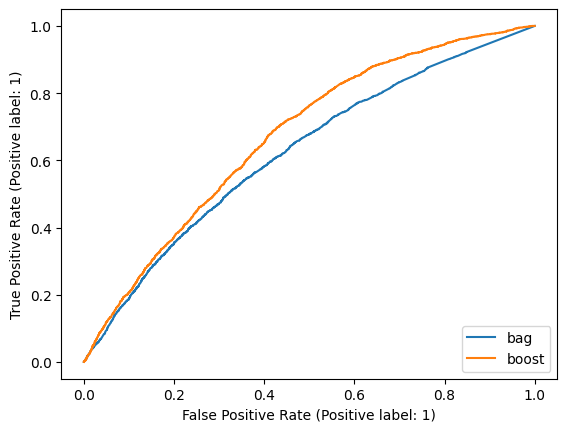

In [51]:
'''T9. Plot ROC-curve.'''
# YOUR CODE HERE
from sklearn.metrics import RocCurveDisplay
rf = RocCurveDisplay.from_estimator(model_bag,
               X_val,
               y_val,
               label = 'bag');

xg = RocCurveDisplay.from_estimator(model_boost,
               X_val,
               y_val,
               ax = rf.ax_,
               label = 'boost');

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, model_bag.predict_proba(X_val)[:,-1])

0.623024250985334

In [44]:
roc_auc_score(y_val, model_boost.predict_proba(X_val)[:,-1])

0.6716199184708302

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`.

In [45]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
# YOUR CODE HERE
model_cr = classification_report(y_val,model_boost.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.71      0.96      0.82      7092
           1       0.50      0.09      0.15      2997

    accuracy                           0.70     10089
   macro avg       0.61      0.53      0.49     10089
weighted avg       0.65      0.70      0.62     10089



**Task 10 Testing**

In [ ]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [48]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE
# Compare permutation importances
result = permutation_importance(model_boost, X_val, y_val)

# Create a DataFrame to store the permutation importances
permutation_importances = pd.DataFrame(
    {'mean_importance': result.importances_mean, 'importances_std':result.importances_std},
    index = X_val.columns
)

# Sort the DataFrame by mean importance in descending order
permutation_importances.sort_values(by='mean_importance', ascending = False, inplace = True)

permutation_importances


,mean_importance,importances_std
Inspection Type,0.013579,0.001309
Latitude,0.008524,0.001211
Longitude,0.007216,0.001451
Facility Type,0.002498,0.000449
Risk,0.001427,0.000746
Zip,0.001150,0.001241


**Task 11 Testing**

In [ ]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

In [49]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

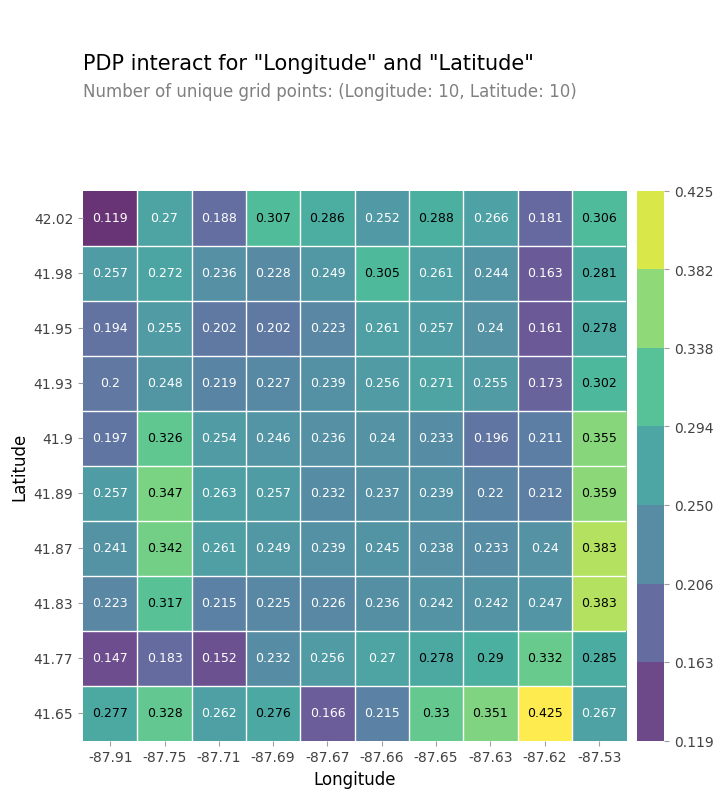

In [52]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
features = ['Longitude', 'Latitude']

# YOUR CODE HERE

interact = pdp_interact(
    model_boost,
    dataset= X_val.dropna(),
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid',feature_names=features);

What do you think? Is there a relationship between location and failing a food saftey inspection? Answer below.

This task will not be autograded - but it is part of completing the challenge.